# Face Emotion Detection

## ML 6140 Final Project

<b><u>Team 1: </u></b>Anuja Prakash Kolse, Saideep Samineni, Aishwarya Kumar Arvind, Rohith Chandra Kandambeth

Prof. Uzair Ahmad

Spring 2024

### This notebook uses the ExpW dataset.

#### Imports

In [2]:
import os
import numpy as np
import cv2
from keras_facenet import FaceNet
from sklearn import svm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from deepface import DeepFace
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
generate_reps = 0

#### Modify labels file from the given dataset

In [43]:
def update_labels(file_path, output_file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    print("Original Data:\n", data.head())  

    last_col = data.columns[-1]

    temp_label_for_5 = -1
    temp_label_for_6 = -2
    temp_label_for_4 = -3

    # Map 5 -> temporary label for 5
    data[last_col] = data[last_col].replace({5: temp_label_for_5})
    print("After mapping 5 to temp:\n", data.head())

    # Map 6 -> temporary label for 6
    data[last_col] = data[last_col].replace({6: temp_label_for_6})
    print("After mapping 6 to temp:\n", data.head())

    # Map 4 -> temporary label for 4
    data[last_col] = data[last_col].replace({4: temp_label_for_4})
    print("After mapping 4 to temp:\n", data.head())

    data[last_col] = data[last_col].replace({temp_label_for_5: 6, temp_label_for_6: 4, temp_label_for_4: 5})
    print("After replacing all temps with new values:\n", data.head())

    data.to_csv(output_file_path, index=False, header=False, sep=' ')

In [44]:
input_path = '/Users/aishwaryakumar/Desktop/Dataset/Image/label.lst'
output_path = '/Users/aishwaryakumar/Desktop/Dataset/Image/updated_label.lst'

In [45]:
update_labels(input_path, output_path)

Original Data:
                      0  1   2    3    4    5        6  7
0  angry_actor_104.jpg  0  28  113  226  141  22.9362  0
1  angry_actor_109.jpg  0  31  157  345  219  50.3056  0
2  angry_actor_120.jpg  1  53   53  372  372  13.9434  2
3   angry_actor_13.jpg  0  77   51  362  388  85.8104  3
4  angry_actor_132.jpg  0  95   31  412  476  82.3948  0
After mapping 5 to temp:
                      0  1   2    3    4    5        6  7
0  angry_actor_104.jpg  0  28  113  226  141  22.9362  0
1  angry_actor_109.jpg  0  31  157  345  219  50.3056  0
2  angry_actor_120.jpg  1  53   53  372  372  13.9434  2
3   angry_actor_13.jpg  0  77   51  362  388  85.8104  3
4  angry_actor_132.jpg  0  95   31  412  476  82.3948  0
After mapping 6 to temp:
                      0  1   2    3    4    5        6  7
0  angry_actor_104.jpg  0  28  113  226  141  22.9362  0
1  angry_actor_109.jpg  0  31  157  345  219  50.3056  0
2  angry_actor_120.jpg  1  53   53  372  372  13.9434  2
3   angry_actor_13.j

In [46]:
def count_label(file_path, label_to_count):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    last_col = data.columns[-1]  

    count = (data[last_col] == label_to_count).sum()
    return count

In [47]:
file_path = '/Users/aishwaryakumar/Downloads/data 6/label/label.lst'

count_of_4 = count_label(file_path, 4)
count_of_5 = count_label(file_path, 5)
count_of_6 = count_label(file_path, 6)

print("Count of '4' in the dataset:", count_of_4)
print("Count of '5' in the dataset:", count_of_5)
print("Count of '6' in the dataset:", count_of_6)

Count of '4' in the dataset: 10559
Count of '5' in the dataset: 7060
Count of '6' in the dataset: 34883


In [48]:
file_path = '/Users/aishwaryakumar/Desktop/Dataset/Image/updated_label.lst'

count_of_4 = count_label(file_path, 4)
count_of_5 = count_label(file_path, 5)
count_of_6 = count_label(file_path, 6)

print("Count of '4' in the dataset:", count_of_4)
print("Count of '5' in the dataset:", count_of_5)
print("Count of '6' in the dataset:", count_of_6)

Count of '4' in the dataset: 34883
Count of '5' in the dataset: 10559
Count of '6' in the dataset: 7060


In [49]:
data = pd.read_csv('/Users/aishwaryakumar/Desktop/Dataset/Image/updated_label.lst', sep=' ', header=None, names=['image_name', 'face_id', 'top', 'left', 'right', 'bottom', 'confidence', 'label'])

In [50]:
data.count()

image_name    91793
face_id       91793
top           91793
left          91793
right         91793
bottom        91793
confidence    91793
label         91793
dtype: int64

In [51]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)  # 20% data as test set

In [52]:
train_data.to_csv('/Users/aishwaryakumar/Desktop/Dataset/train_data.csv', index=False)
test_data.to_csv('/Users/aishwaryakumar/Desktop/Dataset/test_data.csv', index=False)

#### Facenet reps

In [ ]:
embedder = FaceNet()

In [58]:
image_full_path = "/Users/aishwaryakumar/Desktop/Dataset/Image/origin/"

In [60]:
def create_embedd(input_csv_file, output_csv_file):
    input_data = pd.read_csv(input_csv_file)
    for _, row in input_data.iterrows():
        img_name = row[0]
        label = row[-1]
        img = cv2.imread(f"/Users/aishwaryakumar/Desktop/Dataset/Image/origin/{img_name}")
        embeddings = embedder.embeddings([img])
        for i in range(len(embeddings[0])):
            if (i == len(embeddings[0])-1):
                csv_file.write("{} , {}\n".format(embeddings[0][i], label))
            else:
                csv_file.write("{} , ".format(embeddings[0][i]))
    csv_file.close()

In [4]:
train_facenet = "train_expW.csv"
test_facenet = "test_expW.csv"

In [ ]:
if generate_reps:
    csv_file_train = open(train_facenet, "w")
    csv_file_test = open(test_facenet, "w")

In [5]:
train_facenet = "train.csv"
test_facenet = "test.csv"

In [ ]:
if generate_reps:
    csv_file_train = open(train_facenet, "w")
    csv_file_test = open(test_facenet, "w")

labels_file_train = open("/Users/anujaprakashkolse/Downloads/NEU/Semesters/Spring_24/Anuja_ML/Project/labels_train.txt", "r").read().splitlines()
labels_file_test = open("/Users/anujaprakashkolse/Downloads/NEU/Semesters/Spring_24/Anuja_ML/Project/labels_test.txt", "r").read().splitlines()

In [ ]:
if generate_reps:
    create_embeddings(labels_file_train, csv_file_train)
    create_embeddings(labels_file_test, csv_file_test)

1/1 [==============================] - 0s 37ms/step


#### Training for facenet reps

In [6]:
df_train_fn = pd.read_csv(train_facenet, header=None)
df_train_fn.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-0.091919,0.051916,0.001943,-0.027426,-0.048226,-0.031526,0.035893,0.001505,0.021026,0.045596,...,-0.010724,0.093988,0.048333,-0.048847,0.043909,0.018085,-0.026448,-0.006909,0.020144,happy
1,0.009113,0.085887,-0.001893,0.043528,-0.001382,-0.017093,-0.031315,0.083984,-0.038360,-0.085567,...,-0.079466,0.027998,-0.025072,-0.007709,0.010076,0.007181,0.050801,0.084473,0.033736,happy
2,0.044390,0.002805,0.013761,0.071790,0.055609,-0.022597,-0.019615,0.033794,0.009900,0.010250,...,-0.086477,0.007052,0.026665,0.006389,0.028322,0.028942,-0.088447,-0.012365,0.033491,happy
3,0.038794,0.061560,0.047144,-0.017209,0.006046,-0.043545,0.061967,-0.030304,0.040174,-0.062387,...,0.015691,-0.033446,0.097108,0.058203,0.009818,-0.037475,-0.085136,-0.010002,0.004558,happy
4,-0.024505,-0.009263,0.030885,-0.030105,-0.059966,0.035133,0.036233,0.017152,0.017891,0.047850,...,0.084461,-0.007915,-0.035262,-0.043570,-0.000492,0.054782,0.038444,-0.130300,-0.010125,happy


In [7]:
le = LabelEncoder()
X_train_fn = df_train_fn.iloc[:, :-1].to_numpy()  # Features
y_train_fn = le.fit_transform(df_train_fn.iloc[:, -1]) # Target

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgusted': 1, '  fearful': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprised': 6}


In [8]:
clf_fn = svm.SVC(C=100, gamma=0.1, kernel='rbf')
clf_fn.fit(X_train_fn, y_train_fn)

SVC(C=100, gamma=0.1)

In [9]:
y_train_predicted_fn = clf_fn.predict(X_train_fn)

In [10]:
print("Training accuracy: ", accuracy_score(y_train_fn, y_train_predicted_fn))

Training accuracy:  0.6323104253021701


In [11]:
df_test_fn = pd.read_csv(test_facenet, header=None)
df_test_fn.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-0.026437,0.071417,0.092250,-0.020436,0.068914,-0.085590,-0.047277,-0.022069,-0.015329,0.012672,...,-0.050109,0.054241,-0.017658,-0.047313,0.027707,0.004159,0.028107,0.029522,-0.015835,happy
1,0.010547,-0.012303,0.024871,-0.016956,0.054799,-0.012030,0.091366,0.001435,0.103500,-0.013168,...,0.014528,0.062060,-0.123882,-0.023988,-0.011324,0.026197,-0.016000,-0.031684,-0.025887,happy
2,0.074804,-0.039438,0.059720,0.013005,0.000054,0.054525,-0.034021,-0.096049,0.000984,0.008627,...,0.062467,0.072195,-0.063679,0.036140,-0.054468,-0.054542,0.024559,0.061786,-0.060105,happy
3,0.034196,0.044436,0.023843,-0.004037,-0.048426,-0.003144,-0.017279,-0.006708,0.092695,-0.006388,...,0.023160,-0.022248,0.013207,0.010202,-0.029117,-0.010440,0.057155,-0.048184,0.083865,happy
4,-0.033714,0.013179,-0.004578,0.020869,-0.013347,-0.071225,-0.007273,-0.001836,0.017192,-0.071982,...,0.081922,0.009118,-0.029588,0.049512,-0.052274,-0.026313,-0.026901,0.021228,0.018477,happy


In [12]:
X_test_fn = df_test_fn.iloc[:, :-1].to_numpy()  # Features
y_test_fn = le.fit_transform(df_test_fn.iloc[:, -1]) # Target

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgusted': 1, '  fearful': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprised': 6}


In [13]:
y_predicted_fn = clf_fn.predict(X_test_fn)

In [14]:
print("Test accuracy: ", accuracy_score(y_test_fn, y_predicted_fn))

Test accuracy:  0.5057118974644748


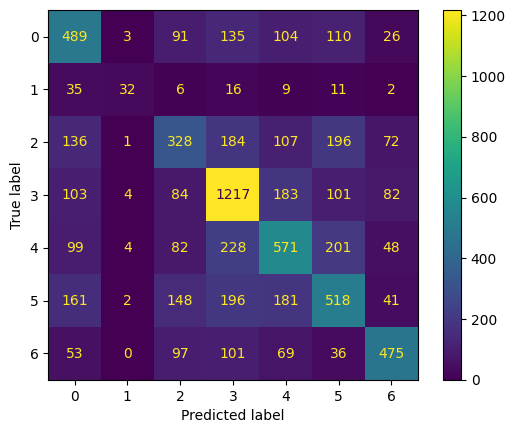

In [15]:
cm_facenet = confusion_matrix(y_test_fn, y_predicted_fn, labels=clf_fn.classes_)
disp = ConfusionMatrixDisplay(cm_facenet, display_labels=clf_fn.classes_)
disp.plot()
plt.show()

Training Accuracy: 0.6323104253021701
Training Precision: 0.6677122158963346
Training Recall: 0.6057125269834154
Training F1 Score: 0.6271997013066145
Test Accuracy: 0.5057118974644748
Test Precision: 0.5247477311485594
Test Recall: 0.46502215191964946
Test F1 Score: 0.48121490639740655


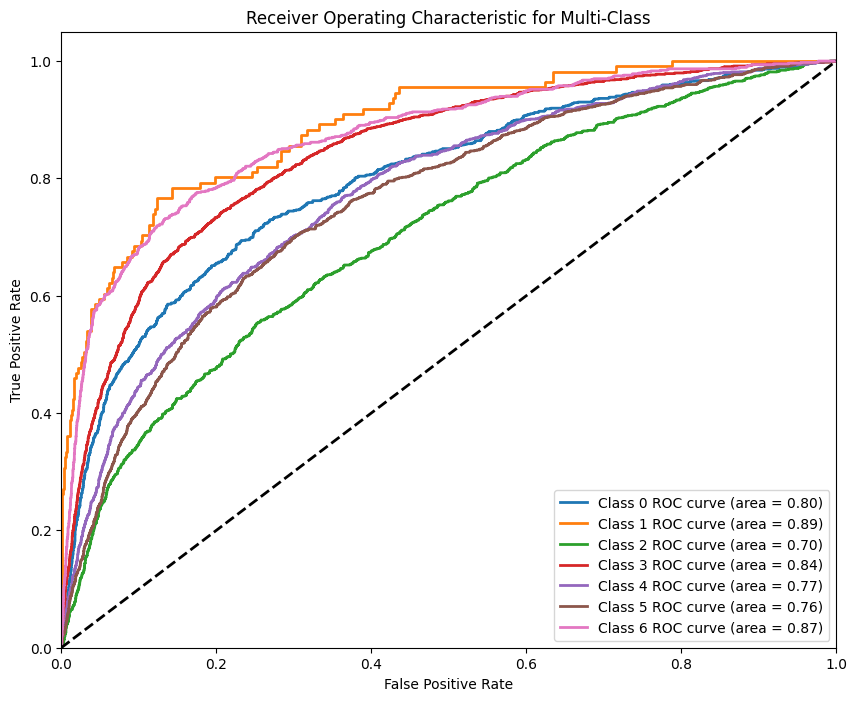

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_bin_train_fn = label_binarize(y_train_fn, classes=clf_fn.classes_)
y_bin_test_fn = label_binarize(y_test_fn, classes=clf_fn.classes_)

train_accuracy = accuracy_score(y_train_fn, y_train_predicted_fn)
train_precision = precision_score(y_train_fn, y_train_predicted_fn, average='macro')
train_recall = recall_score(y_train_fn, y_train_predicted_fn, average='macro')
train_f1_score = f1_score(y_train_fn, y_train_predicted_fn, average='macro')

print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)

test_accuracy = accuracy_score(y_test_fn, y_predicted_fn)
test_precision = precision_score(y_test_fn, y_predicted_fn, average='macro')
test_recall = recall_score(y_test_fn, y_predicted_fn, average='macro')
test_f1_score = f1_score(y_test_fn, y_predicted_fn, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf_fn.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test_fn[:, i], clf_fn.decision_function(X_test_fn)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(clf_fn.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d ROC curve (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### Face reps using Deepface

In [17]:
models = ["VGG-Face", "Facenet", "OpenFace", "Dlib", "ArcFace"]

In [ ]:
def create_deepface_reps(labels_file, csv_file):
    for line in labels_file:
        split_arr = line.split(",")
        img_path = split_arr[0]
        label = split_arr[1]
        try:
            embeddings = DeepFace.represent(img_path, model_name = models[3])#, enforce_detection=False)
            csv_file.write("{} , {}\n".format(embeddings[0]['embedding'], label))
        except Exception as e:
            continue
    csv_file.close()

In [18]:
train_vgg = "train_vgg.csv"
test_vgg = "test_vgg.csv"

In [ ]:
if generate_reps:
    csv_file_train_df = open(train_vgg, "w")
    csv_file_test_df = open(test_vgg, "w")

In [ ]:
if generate_reps:
    create_deepface_reps(labels_file_train, csv_file_train_df)
    create_deepface_reps(labels_file_test, csv_file_test_df)

#### Training using Deepface

In [31]:
final_train = "train_vgg_final.csv"
final_test = "test_vgg_final.csv"

In [32]:
def helper(fi, fi1):
    for i in range(len(fi)):
        x = fi[i].split(']')
        line =  (x[0]+ x[1]).split('[')[1]
        fi1.write(line+"\n")
    fi1.close()

In [34]:
df_train = pd.read_csv(final_train, header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,0.019521,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.003121,0.0,...,0.0,0.019897,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,happy
1,0.0,0.000000,0.100856,0.0,0.0,0.008221,0.049338,0.0,0.000000,0.0,...,0.0,0.050106,0.057207,0.053507,0.0,0.0,0.0,0.0,0.0,happy
2,0.0,0.000000,0.033693,0.0,0.0,0.013898,0.119639,0.0,0.000000,0.0,...,0.0,0.083991,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,happy
3,0.0,0.062594,0.054887,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.025678,0.000000,0.0,0.0,0.0,0.0,0.0,happy
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.026820,0.000000,0.0,0.0,0.0,0.0,0.0,happy


In [35]:
le = LabelEncoder()
X_train = df_train.iloc[:, :-1].to_numpy()  # Features
y_train = le.fit_transform(df_train.iloc[:, -1]) # Target

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgusted': 1, '  fearful': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprised': 6}


In [36]:
clf = svm.SVC(C=100, gamma=0.1, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=100, gamma=0.1)

In [37]:
y_train_predicted = clf.predict(X_train)

In [24]:
print("Training accuracy: ", accuracy_score(y_train, y_train_predicted))

Training accuracy:  0.996


In [25]:
df_test = pd.read_csv(final_test, header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.074489,0.0,0.0,0.0,0.000000,0.0,0.031889,0.0,0.0,happy
1,0.006106,0.089214,0.0,0.0,0.032623,0.0,0.0,0.000000,0.105565,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,happy
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,happy
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.014152,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.013619,0.0,0.0,happy
4,0.000000,0.024723,0.0,0.0,0.000000,0.0,0.0,0.044559,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.010733,0.0,0.000000,0.0,0.0,happy


In [26]:
X_test = df_test.iloc[:, :-1].to_numpy()  
y_test = le.fit_transform(df_test.iloc[:, -1]) 

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'  angry': 0, '  disgusted': 1, '  fearful': 2, '  happy': 3, '  neutral': 4, '  sad': 5, '  surprised': 6}


In [27]:
y_predicted = clf.predict(X_test)

In [28]:
print("Test accuracy: ", accuracy_score(y_test, y_predicted))

Test accuracy:  0.6673003802281369


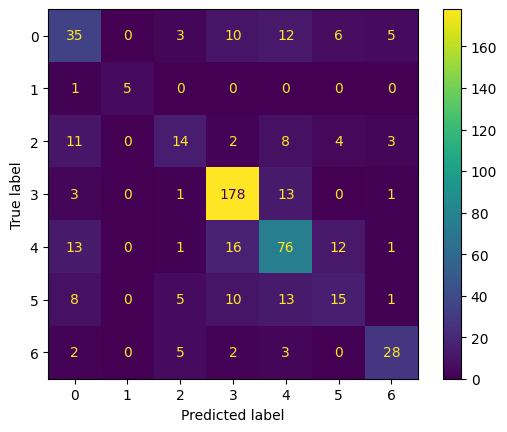

In [29]:
cm_vgg = confusion_matrix(y_test, y_predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm_vgg, display_labels=clf.classes_)
disp.plot()
plt.show()

Training Accuracy: 0.996
Training Precision: 0.9936539798375411
Training Recall: 0.9933428345353603
Training F1 Score: 0.9934396787628101
Test Accuracy: 0.6673003802281369
Test Precision: 0.6442969371865984
Test Recall: 0.5992720970140105
Test F1 Score: 0.6169088328398322


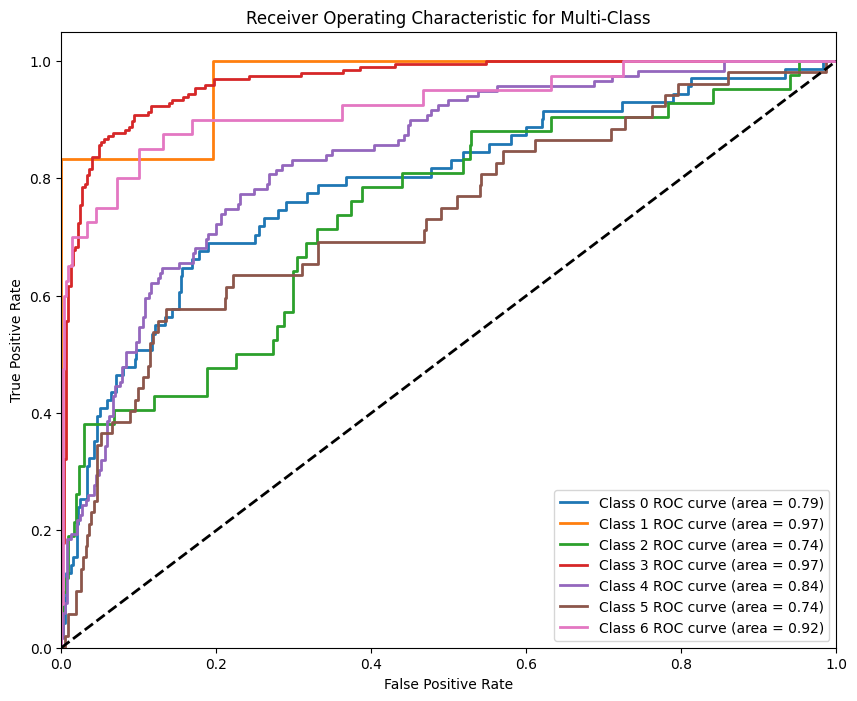

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_bin_train_fn = label_binarize(y_train, classes=clf.classes_)
y_bin_test_fn = label_binarize(y_test, classes=clf.classes_)

train_accuracy = accuracy_score(y_train, y_train_predicted)
train_precision = precision_score(y_train, y_train_predicted, average='macro')
train_recall = recall_score(y_train, y_train_predicted, average='macro')
train_f1_score = f1_score(y_train, y_train_predicted, average='macro')

print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)

test_accuracy = accuracy_score(y_test, y_predicted)
test_precision = precision_score(y_test, y_predicted, average='macro')
test_recall = recall_score(y_test, y_predicted, average='macro')
test_f1_score = f1_score(y_test, y_predicted, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test_fn[:, i], clf.decision_function(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class %d ROC curve (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


### MLP Test

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', solver='adam', max_iter=1000).fit(X_train, y_train)

In [ ]:
y_predicted_mlp = mlp_clf.predict(X_test)

In [ ]:
print("Test accuracy: ", accuracy_score(y_test, y_predicted_mlp))

Test accuracy:  0.6482889733840305
